In [1]:
## testing multidark
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kde
import h5py
import astropy.io.fits as fits
import csv
import pandas as pd
import h5py
import tables
import pickle
import os
from astropy.table import Table
from astropy.coordinates import SkyCoord
from tqdm import tqdm
from astropy.io import ascii
import os

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import timeit

## Append all clusters together
z = 0.00, z=0.49 and z=1.03

In [16]:
clusters_z0p00_file = '/global/cscratch1/sd/zzhang13/MultiDark/MDPL2_ROCKSTAR_Halos/z0p00/' + 'MDPL2_halos_DS_Ngal_Dgal_lt_2_allM_mah_z0p00.p'
clusters_z0p49_file = '/global/cscratch1/sd/zzhang13/MultiDark/MDPL2_ROCKSTAR_Halos/z0p49/' + 'MDPL2_halos_DS_Ngal_Dgal_lt_2_allM_mah_z0p49.p'
clusters_z1p03_file = '/global/cscratch1/sd/zzhang13/MultiDark/MDPL2_ROCKSTAR_Halos/z1p03/' + 'MDPL2_halos_DS_Ngal_Dgal_lt_2_allM_mah_z1p03.p'

clusters_files = [clusters_z0p00_file, clusters_z0p49_file, clusters_z1p03_file]

In [17]:
with open(clusters_z0p00_file, 'rb') as handle:
    matched_halo_df = pickle.load(handle)

In [18]:
matched_halo_df = pd.DataFrame(columns=matched_halo_df.columns) ##empty DF

In [19]:
matched_halo_df

,scale,id,pid,mvir,rvir,x,y,z,M200b,M200c,...,delta_sigma,rs,T/|U|,Halfmass_Scale,Acc_Rate_Inst,Acc_Rate_100Myr,Acc_Rate_1*Tdyn,Acc_Rate_2*Tdyn,Acc_Rate_Mpeak,c_vir


In [20]:
for file in iter(clusters_files):
    with open(file,'rb') as handle:
        cur_df = pickle.load(handle)
    matched_halo_df = matched_halo_df.append(cur_df, ignore_index=True)

In [23]:
matched_halo_df.groupby('scale').mean()

,mvir,rvir,x,y,z,CentralMvir,StellarMass,Ngal,rs,T/|U|,Halfmass_Scale,Acc_Rate_Inst,Acc_Rate_100Myr,Acc_Rate_1*Tdyn,Acc_Rate_2*Tdyn,Acc_Rate_Mpeak,c_vir,Mmvir_all
scale,,,,,,,,,,,,,,,,,,
0.4922,1.024424e+14,1107.860760,637.297195,369.528321,504.154151,9.539071e+13,1.480425e+11,77.019499,296.874831,0.708872,0.382598,30636.496058,30636.496058,31192.426741,30846.708914,31359.380223,NaN,1.026076e+14
0.6712,1.614951e+14,1200.186226,242.059814,582.849578,486.953972,1.435792e+14,1.512220e+11,96.681333,293.570810,0.694499,0.488354,29366.655967,29366.655967,29564.152260,28431.584600,28399.903067,NaN,1.618252e+14
1.0000,3.085148e+14,1279.278585,306.319320,671.824071,509.171483,2.485489e+14,1.940698e+11,133.312571,269.347452,0.658473,0.651673,25891.225377,25891.225377,27820.118000,29155.635539,29985.539120,5.620467,NaN


In [40]:
mass_bin_edges = [5e13, 1e14, 2e14, 5e14, 1e15]
mass_bins = [[mass_bin_edges[i],mass_bin_edges[i+1]] for i in range(len(mass_bin_edges)-1)]

a_bins = [1, 0.6712, 0.4922]
column_name ='Acc_Rate_2*Tdyn'

In [43]:
## Testing the file properties. 
r_bins_log_norm = np.linspace(-1,1,21)
r_bins_lin_norm = 10**r_bins_log_norm
r_cent_log_norm= (r_bins_log_norm[1:] + r_bins_log_norm[:-1])/2
r_cent_lin_norm = 10**r_cent_log_norm

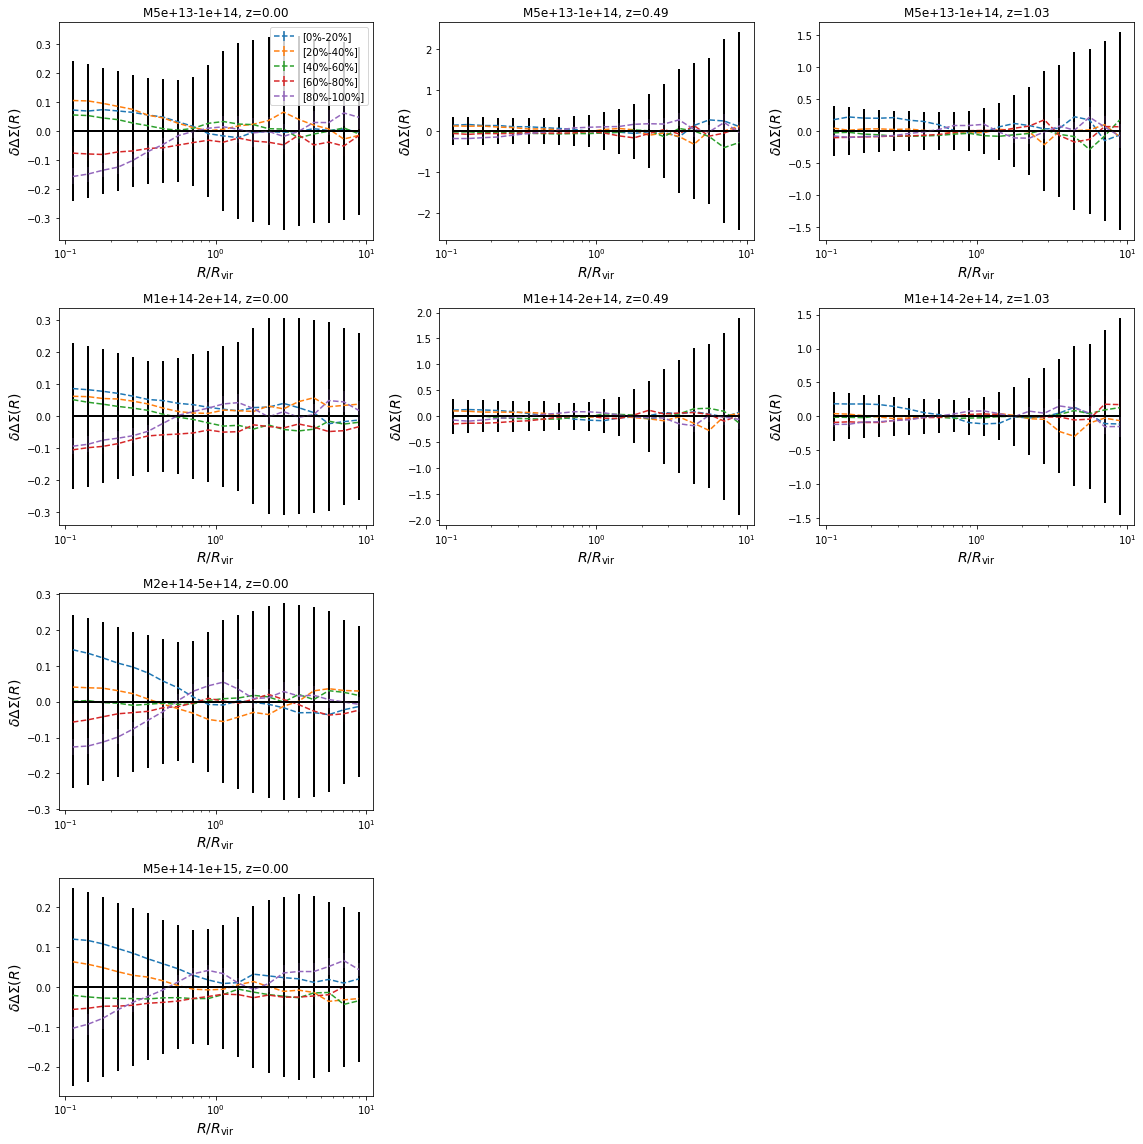

In [59]:
from scipy import stats
fig, axs = plt.subplots(4,3,figsize=(16,16))

split_samp_bins_edge = [0, 20, 40, 60, 80, 100]
x_var_bin = [[] for i in range(len(split_samp_bins_edge)-1)]
bin_num = len(x_var_bin)

for i, cur_mass_bin in enumerate(mass_bins):
    for j, cur_a_bin in enumerate(a_bins):     
        mass_min = cur_mass_bin[0]; mass_max = cur_mass_bin[1]
        
        mask = (matched_halo_df.mvir >= mass_min) & (matched_halo_df.mvir < mass_max) & (matched_halo_df.scale == cur_a_bin) 
        all_df = matched_halo_df[mask]
        
        if len(all_df) < 100: 
            axs[i,j].set_visible(False)
            continue
        DS_all = np.vstack(all_df['delta_sigma'])
        
        for k in range(bin_num):
            bin_low = split_samp_bins_edge[k]
            bin_high = split_samp_bins_edge[k+1]

            x_var = all_df[column_name]
            percentile_x_var = np.vectorize(lambda x: stats.percentileofscore(x_var, x))(x_var)
            mask = (percentile_x_var >= bin_low) & (percentile_x_var < bin_high)
            x_var_bin[i] = x_var[mask]

            cur_df = all_df[mask]
            DS_cur = np.vstack(cur_df['delta_sigma'])
            DS_diff = (np.mean(cur_df['delta_sigma'],axis=0) - np.mean(DS_all,axis=0))/np.mean(DS_all,axis=0)
            DS_diff_err = np.std(DS_cur,axis=0)/np.mean(DS_all,axis=0) * 1/np.sqrt(len(DS_cur))

            #axs[i,j].plot(r_cent_lin_norm, np.mean(cur_df['delta_sigma'],axis=0), \
            #                label='[{:d}%-{:d}%]'.format(bin_low, bin_high), linewidth=2, alpha=0.5, linestyle='dashed')

            axs[i,j].errorbar(r_cent_lin_norm, DS_diff, yerr=DS_diff_err, linestyle='dashed', label='[{:d}%-{:d}%]'.format(bin_low, bin_high))
            axs[i,j].errorbar(r_cent_lin_norm, np.zeros_like(r_cent_lin_norm), yerr=np.std(DS_all,axis=0)/np.mean(DS_all,axis=0), linestyle='solid', color='black')

        axs[i,j].set_xscale('log')
        #axs[i,j].set_yscale('log')
        axs[i,j].set_xlabel(r'$R/R_{\rm vir}$', fontsize=14)
        axs[i,j].set_ylabel(r'$\delta\Delta\Sigma(R)$', fontsize=14)
        axs[i,j].set_title('M{:.2g}-{:.2g}, z={:.2f}'.format(mass_min, mass_max, 1/cur_a_bin-1))
        
axs[0,0].legend()
axs[2, 1].set_visible(False)
fig.tight_layout()
plt.show()
        
         
            

In [ ]:
from scipy import stats
'''
split_samp_bins: Defines bin edges in terms of percentile of the samples split. Closed in low end and open in high end, e.g. [0,0.5,1] creates two bins [0,0.5) and [0.5,1).
Default is two bins high and low split by the median. 
'''

def plot_corr_split_samp(column_name, nBoot=20, split_samp_bins_edge = [0,0.5,1]):

    ##Split the sample by percentile according to split_samp_bins

    #print('percentile_var \n', percentile_var)

    ##Create bins with bin edges
    x_var_bin = [[] for i in range(len(split_samp_bins_edge)-1)]
    bin_num = len(x_var_bin)
    
    f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True, figsize=(8,8))

    mask = (matched_halo_df.mvir >= 1e14) & (matched_halo_df.mvir < 2e14)
    all_df = matched_halo_df[mask]
    DS_all = np.vstack(all_df['delta_sigma'])
    for i in range(bin_num):
        bin_low = split_samp_bins_edge[i]
        bin_high = split_samp_bins_edge[i+1]
        
        x_var = all_df[column_name]
        percentile_x_var = np.vectorize(lambda x: stats.percentileofscore(x_var, x))(x_var)
        mask = (percentile_x_var >= bin_low) & (percentile_x_var < bin_high)
        x_var_bin[i] = x_var[mask]

        cur_df = all_df[mask]
        DS_cur = np.vstack(cur_df['delta_sigma'])
        DS_diff = (np.mean(cur_df['delta_sigma'],axis=0) - np.mean(DS_all,axis=0))/np.mean(DS_all,axis=0)
        DS_diff_err = np.std(DS_cur,axis=0)/np.mean(DS_all,axis=0) * 1/np.sqrt(len(DS_cur))

        a0.plot(r_cent_lin_norm, np.mean(cur_df['delta_sigma'],axis=0), \
                        label='[{:d}%-{:d}%]'.format(bin_low, bin_high), linewidth=2, alpha=0.5, linestyle='dashed')

        a1.errorbar(r_cent_lin_norm, DS_diff, yerr=DS_diff_err, linestyle='dashed')

    a0.errorbar(r_cent_lin_norm, np.mean(DS_all,axis=0), yerr=np.std(DS_all,axis=0), \
                label='All', linewidth=2, alpha=0.5, linestyle='solid', color='black')

    a0.set_xscale('log'); a0.set_yscale('log')
    a0.set_ylabel(r'$\Delta\Sigma$', fontsize=14)
    a0.legend()

    a1.set_xscale('log')
    a1.axhline(0, linestyle='solid', color='black')
    a1.set_xlabel(r'$R/R_{\rm vir}$', fontsize=14)
    a1.set_ylabel(r'$\delta\Delta\Sigma(R)$', fontsize=14)

    f.tight_layout()

    plt.show()

    return